# Predikcija pogodaka u NBA-u  

## Uvod i motivacija

Ovakvim i sličnim projektima se želi poboljšati efikasnost šutera u NBA-u tako da se momčadima omogući lakša analiza i procjena mjesta s kojeg bi u nekoj situaciji bilo najpogodnije pucati na koš i time optimizirati vjerojatnosti pobjede. To se želi postići upotrebom statističke analize podataka te raznih algoritama strojnog učenja. 

Projekt se temelji na članku [Predicting NBA Shots](http://cs229.stanford.edu/proj2017/final-reports/5132133.pdf).


Istraživanje provedeno u članku je:
 - Sekundarno istraživanje prema tipu izvora informacija jer se informacije općenito temelje na znanstvenoj literaturi i drugim dokumentima koje je sastavio drugi istraživač te jer se u članku želi sintetizirati postojeće znanje.
 - Primijenjeno istraživanje prema tipu svrhe jer se izravno koristi za primjenu u košarkaškoj industriji
 - Studija presjeka ili sinkrono istraživanje prema tipu vremena provedbe jer se promatra šuterska aktivnost u jednom trenutku
 - Mješovito istraživanje prema tipu prikupljanja podataka jer se kao izvor informacija koriste i primarni i sekundarni izvori
 - Promatračko istraživanje prema tipu stupnja manipulacije varijablama jer se odvija analiza fenomena u njegovom prirodnom    kontekstu te istraživač ne intervenira izravno, već ograničava svoje sudjelovanje na mjerenje varijabli potrebnih za istraživanje
 - Korelacijsko (correlational) istraživanje prema tipu dubine jer je svrha identificirati odnos između dvije ili više varijabli
 - Hipotetičko-deduktivno istraživanje prema tipu zaklučka jer se odvija promatranje stvarnosti kako bi postavila hipoteza, zatim pomoću dedukcije donio zaključak i konačno ga provjerili ili odbacili kroz iskustvo

In [51]:
# import-anje potrebnih library-a
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

# Početni pregled podataka

In [2]:
pd.set_option('max_columns',None)
shot_logs = pd.read_csv('shot_logs.csv')

print("ATRIBUTI DATASET-A: ")
print(shot_logs.columns.values)
    
print("BROJ PRIMJERA: ", len(shot_logs))


ATRIBUTI DATASET-A: 
['GAME_ID' 'MATCHUP' 'LOCATION' 'W' 'FINAL_MARGIN' 'SHOT_NUMBER' 'PERIOD'
 'GAME_CLOCK' 'SHOT_CLOCK' 'DRIBBLES' 'TOUCH_TIME' 'SHOT_DIST' 'PTS_TYPE'
 'SHOT_RESULT' 'CLOSEST_DEFENDER' 'CLOSEST_DEFENDER_PLAYER_ID'
 'CLOSE_DEF_DIST' 'FGM' 'PTS' 'player_name' 'player_id']
BROJ PRIMJERA:  128069


Pojašnjenja značajki:
 - GAME_ID - jedinstveni identifikator svake utakmice
 - MATCHUP - datum odigravanja utakmice te informacija o tome koje su ekipe igrale
 - LOCATION - informacija o tome gdje se igra(A - Away(u gostima) ili H - Home(na domaćem terenu))
 - W - informaicija o tome tko je pobjedio
 - FINAL_MARGIN - konaćna razlika u broju poena
 - SHOT_NUMBER - broj Šuta u utakmici
 - PERIOD - informacija o tome o kojoj se četvrtini radi ili o kojem se periodu produžetaka radi(1 - 4 -> broj četvrtine, 5 - 7 -> broj perioda u produžecima)
 - GAME_CLOCK - vrijeme koje je proteklo u trenutnom periodu
 - SHOT_CLOCK - sekunda u kojoj je pucan šut(sekunde se gledaju s obzirom na jedan napad - u 24 sekunde)
 - DRIBBLES - luka ukrcavanja (C = Cherbourg, Q = Queenstown, S = Southampton)
 - TOUCH_TIME - tip driblinga prije šuta
 - SHOT_DIST - udaljenost do koša
 - PTS_TYPE - broj poena koji bi se dobio kad bi se zabio šut(2 ili 3)
 - SHOT_RESULT - rezultat šuta(pogođen('made') ili nepogođen('missed'))
 - CLOSEST_DEFENDER - najbliži igrač u obrani
 - CLOSEST_DEFENDER_PLAYER_ID - jedinstveni identifikator igrača u obrani
 - CLOSE_DEF_DIST - udaljenost od igrača u obrani
 - FGM - 'field goal made' - rezultat je li pogođen šut
 - PTS - broj dobivenih poena šutom
 - player_name - ime šutera
 - player_id - jedinstveni identifikator šutera

In [3]:
shot_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

### Jedinstvene vrijednosti značajki

In [4]:
shot_logs.nunique()

GAME_ID                        904
MATCHUP                       1808
LOCATION                         2
W                                2
FINAL_MARGIN                    88
SHOT_NUMBER                     38
PERIOD                           7
GAME_CLOCK                     719
SHOT_CLOCK                     241
DRIBBLES                        33
TOUCH_TIME                     313
SHOT_DIST                      448
PTS_TYPE                         2
SHOT_RESULT                      2
CLOSEST_DEFENDER               473
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSE_DEF_DIST                 299
FGM                              2
PTS                              3
player_name                    281
player_id                      281
dtype: int64

In [5]:
shot_logs.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


### Nedostajući podaci

In [6]:
shot_logs.isna().sum()

GAME_ID                          0
MATCHUP                          0
LOCATION                         0
W                                0
FINAL_MARGIN                     0
SHOT_NUMBER                      0
PERIOD                           0
GAME_CLOCK                       0
SHOT_CLOCK                    5567
DRIBBLES                         0
TOUCH_TIME                       0
SHOT_DIST                        0
PTS_TYPE                         0
SHOT_RESULT                      0
CLOSEST_DEFENDER                 0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSE_DEF_DIST                   0
FGM                              0
PTS                              0
player_name                      0
player_id                        0
dtype: int64

samo atribut SHOT_CLOCK ima nedostajuće vrijednosti, on nam može biti koristan jer govori koliko je šutero još ostalo vremena za taj napad. Ideja je zasad da se izbace samo retci koji imaju Nan vrijednost.

In [7]:
shot_logs = shot_logs.loc[shot_logs.SHOT_CLOCK.notnull(), :]

### Stršeći podatci

In [8]:
# analiza svih atributa
shot_logs.describe(include='all')

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
count,1.225020e+05,122502,122502,122502,122502.000000,122502.000000,122502.000000,122502,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502,122502,122502.000000,122502.000000,122502.000000,122502.000000,122502,122502.000000
unique,NaN,1792,2,2,NaN,NaN,NaN,718,NaN,NaN,NaN,NaN,NaN,2,473,NaN,NaN,NaN,NaN,281,NaN
top,NaN,"FEB 07, 2015 - DAL vs. POR",A,W,NaN,NaN,NaN,11:46,NaN,NaN,NaN,NaN,NaN,missed,"Ibaka, Serge",NaN,NaN,NaN,NaN,lamarcus aldridge,NaN
freq,NaN,102,61315,62149,NaN,NaN,NaN,265,NaN,NaN,NaN,NaN,NaN,66622,802,NaN,NaN,NaN,NaN,1010,NaN
mean,2.140045e+07,NaN,NaN,NaN,0.252396,6.476164,2.471454,NaN,12.453344,1.989233,2.748202,13.443758,2.258363,NaN,NaN,159120.427977,4.121706,0.456156,1.005469,NaN,157334.912965
std,2.578228e+02,NaN,NaN,NaN,13.311418,4.681245,1.137898,NaN,5.763265,3.411188,2.957237,8.777113,0.437736,NaN,NaN,78689.677900,2.751587,0.498076,1.131129,NaN,79304.953702
min,2.140000e+07,NaN,NaN,NaN,-53.000000,1.000000,1.000000,NaN,0.000000,0.000000,-100.500000,0.000000,2.000000,NaN,NaN,708.000000,0.000000,0.000000,0.000000,NaN,708.000000
25%,2.140023e+07,NaN,NaN,NaN,-8.000000,3.000000,1.000000,NaN,8.200000,0.000000,0.900000,4.700000,2.000000,NaN,NaN,200745.000000,2.300000,0.000000,0.000000,NaN,101162.000000
50%,2.140045e+07,NaN,NaN,NaN,1.000000,5.000000,2.000000,NaN,12.300000,1.000000,1.600000,13.400000,2.000000,NaN,NaN,201949.000000,3.700000,0.000000,0.000000,NaN,201939.000000
75%,2.140067e+07,NaN,NaN,NaN,9.000000,9.000000,3.000000,NaN,16.675000,2.000000,3.700000,22.400000,3.000000,NaN,NaN,203079.000000,5.300000,1.000000,2.000000,NaN,202704.000000


nema stršećih vrijednosti. Također, ne bi trebalo biti nekonzistentnih podataka

Također, atributi FGM i PTS su savršeni prediktori ciljane varijable pa se zato neće koristiti u predikciji.

# Vizualizacija podataka

## Kategorički podaci

Uočava se da su sljedeći atributi kategorički: *MATCHUP*, *LOCATION*, *W*, *DRIBBLES*, *SHOT_RESULT*, *CLOSEST_DEFENDER*, 
*CLOSEST_DEFENDER_PLAYER_ID*, *player_name*, *player_id*, *PTS_TYPE*, *SHOT_NUMBER*, *PERIOD* i *GAME_CLOCK*

vizulizirat će se sljedeća 6 atributa: LOCATION, W, DRIBBLES, SHOT_RESULT, PTS_TYPE i  SHOT_NUMBER. Dok se ostali neće budući su ostali atributi id-ovi igrača ili utakmica.

In [9]:
# uklanjanje atributa s više od dvije kategoričke vrijednosti
shot_logs.drop(columns=['GAME_ID', 'MATCHUP', 'CLOSEST_DEFENDER','CLOSEST_DEFENDER_PLAYER_ID', 'player_name','player_id'])

,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS
0,A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,1.3,1,2
1,A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,6.1,0,0
3,A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,3.4,0,0
4,A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,1.1,0,0
5,A,W,24,6,2,8:15,9.1,2,4.4,18.4,2,missed,2.6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128063,A,L,-16,4,2,5:05,15.3,2,1.6,8.9,2,made,5.7,1,2
128064,A,L,-16,5,3,1:52,18.3,5,6.2,8.7,2,missed,0.8,0,0
128065,A,L,-16,6,4,11:28,19.8,4,5.2,0.6,2,made,0.6,1,2
128066,A,L,-16,7,4,11:10,23.0,2,4.2,16.9,2,made,4.2,1,2


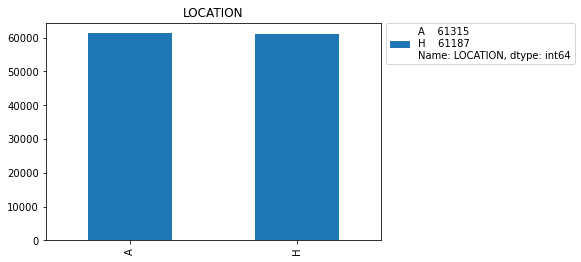

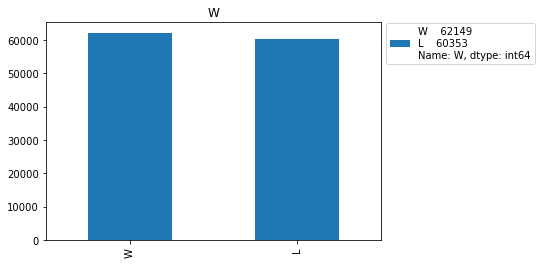

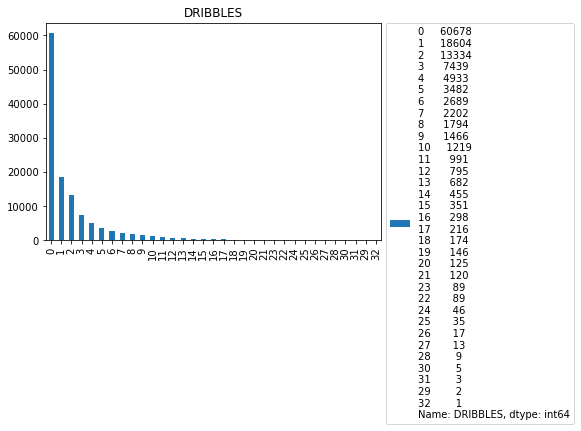

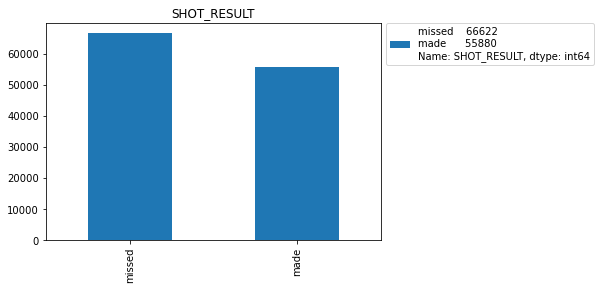

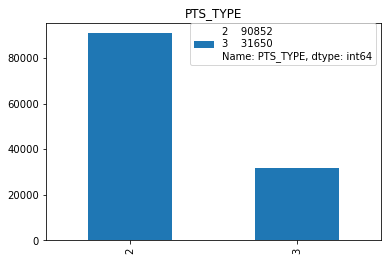

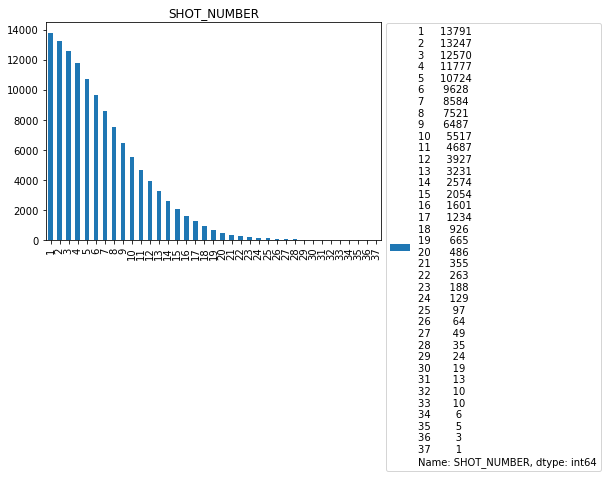

<Figure size 432x288 with 0 Axes>

In [10]:
categorical_features = ['LOCATION', 'W', 'DRIBBLES', 'SHOT_RESULT','PTS_TYPE','SHOT_NUMBER']
for i, categorical_feature in enumerate(shot_logs[categorical_features]):
    shot_logs[categorical_feature].value_counts().plot(kind="bar",label=str(shot_logs[categorical_feature].value_counts())).set_title(categorical_feature)
    plt.legend(bbox_to_anchor=(1, 1.022))
    plt.figure()
plt.show()

posebno za atribut CLOSEST_DEFENDER ću iznijeti vrijednosti bez histograma jer bi bio nepregledan. Iz ispisa vidimo npr. da je Serge Ibaka najčešće najbliži igrač u obrani u ovom dataset-u te da je ukupno zabilježeno 473 igrača u ovoj ulozi.

In [11]:
shot_logs['CLOSEST_DEFENDER'].value_counts()

Ibaka, Serge           802
Jordan, DeAndre        786
Green, Draymond        737
Gasol, Pau             716
Millsap, Paul          702
                      ... 
Raduljica, Miroslav      1
Caboclo, Bruno           1
Moreland, Eric           1
Ledo, Ricky              1
Murry, Toure             1
Name: CLOSEST_DEFENDER, Length: 473, dtype: int64

### Korelacija kategoričkih varijabli

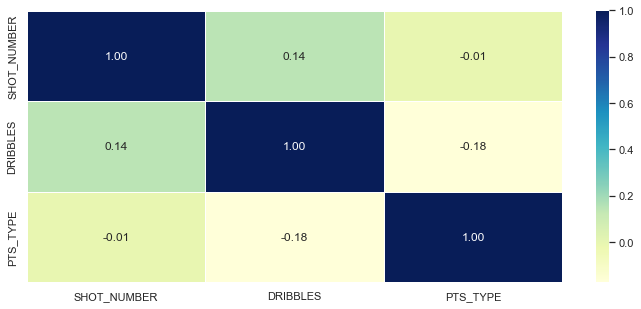

In [12]:
shot_logs_numeric = shot_logs.loc[:,shot_logs.columns.isin(['DRIBBLES','PTS_TYPE','SHOT_NUMBER'])]
sns.set(rc={'figure.figsize':(12,5)})
sns.heatmap(shot_logs_numeric.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.show()

Nema naznaka na jaču korelaciju.

## Numerički podaci

Uočava se da su sljedeći atributi numerički: *FINAL_MARGIN*, *SHOT_CLOCK*, *TOUCH_TIME*, *SHOT_DIST*

Pogledajmo atribut GAME_CLOCK, njegov je oblik MM:SS tj. prikazan je minutama i sekundama,a želimo ga prebaciti u samo sekunde.

In [13]:
print(shot_logs['GAME_CLOCK'])

# funkcija koja prima time string u obliku MM:SS i vraća vrijednost u sekundama
def get_seconds(time_string):
    date_time = datetime.datetime.strptime(time_string, "%M:%S")
    a_timedelta = date_time - datetime.datetime(1900, 1, 1)
    seconds = a_timedelta.total_seconds()
    return seconds

shot_logs['GAME_CLOCK']=shot_logs['GAME_CLOCK'].apply(get_seconds)

print(shot_logs['GAME_CLOCK'])

0          1:09
1          0:14
3         11:47
4         10:34
5          8:15
          ...  
128063     5:05
128064     1:52
128065    11:28
128066    11:10
128067     2:37
Name: GAME_CLOCK, Length: 122502, dtype: object
0          69.0
1          14.0
3         707.0
4         634.0
5         495.0
          ...  
128063    305.0
128064    112.0
128065    688.0
128066    670.0
128067    157.0
Name: GAME_CLOCK, Length: 122502, dtype: float64


Dalje, obavlja se spajanje atributa GAME_CLOCK i PERIOD u novi atribut TOTAL_GAME_TIME koji omogućava razlikovanje istih vremena za različite četvrtine. 
Zato što npr. nije isto pucati u zadnjoj minuti prve četvrtine i u zadnjoj minuti zadnje četvrtine.

In [14]:
print(shot_logs[['GAME_CLOCK','PERIOD']])
shot_logs['TOTAL_GAME_TIME'] = shot_logs['GAME_CLOCK'] + (shot_logs['PERIOD'] - 1) * 12 * 60
    
shot_logs.loc[shot_logs.PERIOD>5, 'TOTAL_GAME_TIME'] =  shot_logs.loc[shot_logs.PERIOD>5, 'TOTAL_GAME_TIME'] - (shot_logs.loc[shot_logs.PERIOD>5, 'PERIOD'] - 5) * 7 * 60
print(shot_logs[['GAME_CLOCK','PERIOD','TOTAL_GAME_TIME']])

# budući da su atributi GAME_CLOCK i PERIOD sadržani u atributu TOTAL_GAME_TIME, oni nam više ne trebaju pa se brišu
shot_logs.drop(columns=['GAME_CLOCK', 'PERIOD'])

        GAME_CLOCK  PERIOD
0             69.0       1
1             14.0       1
3            707.0       2
4            634.0       2
5            495.0       2
...            ...     ...
128063       305.0       2
128064       112.0       3
128065       688.0       4
128066       670.0       4
128067       157.0       4

[122502 rows x 2 columns]
        GAME_CLOCK  PERIOD  TOTAL_GAME_TIME
0             69.0       1             69.0
1             14.0       1             14.0
3            707.0       2           1427.0
4            634.0       2           1354.0
5            495.0       2           1215.0
...            ...     ...              ...
128063       305.0       2           1025.0
128064       112.0       3           1552.0
128065       688.0       4           2848.0
128066       670.0       4           2830.0
128067       157.0       4           2317.0

[122502 rows x 3 columns]


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,TOTAL_GAME_TIME
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,69.0
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,14.0
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,1427.0
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,1354.0
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,9.1,2,4.4,18.4,2,missed,"Williams, Deron",101114,2.6,0,0,brian roberts,203148,1215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128063,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,4,15.3,2,1.6,8.9,2,made,"Sullinger, Jared",203096,5.7,1,2,jarrett jack,101127,1025.0
128064,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,5,18.3,5,6.2,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127,1552.0
128065,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,6,19.8,4,5.2,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127,2848.0
128066,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,7,23.0,2,4.2,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127,2830.0


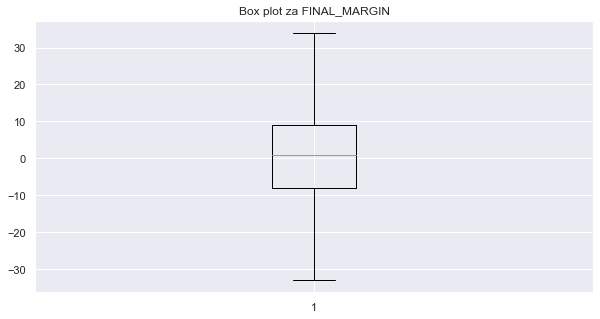

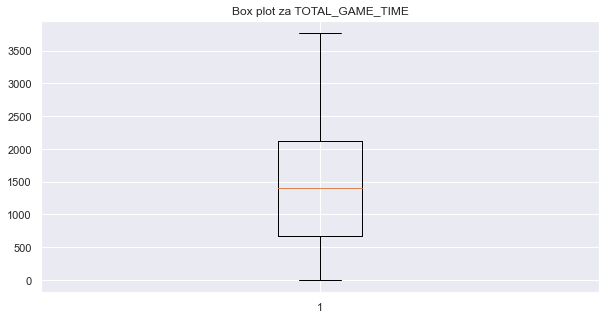

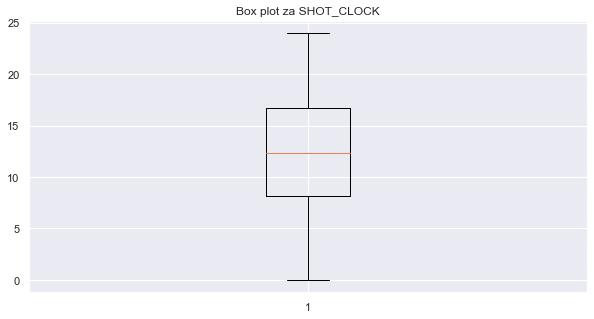

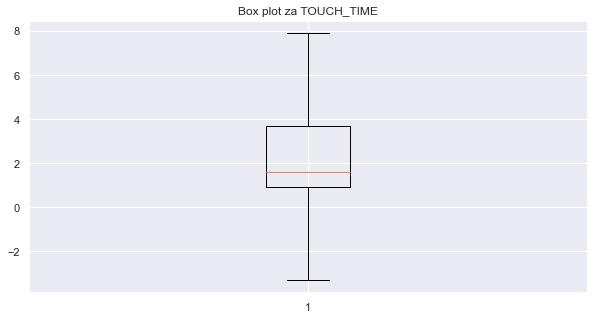

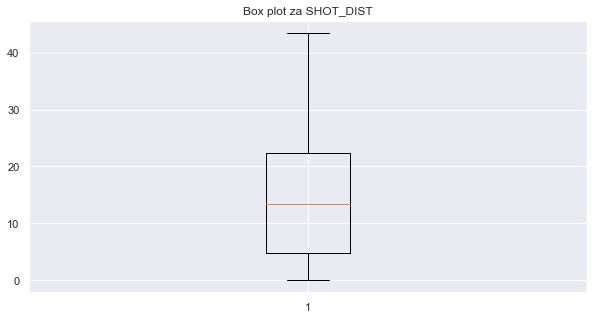

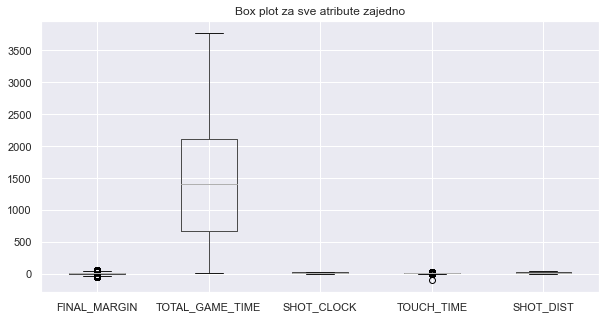

In [15]:
plt.figure(figsize=(10,5))
plt.boxplot(shot_logs.FINAL_MARGIN, showfliers=False)
plt.title('Box plot za FINAL_MARGIN')
plt.figure(figsize=(10,5))

plt.boxplot(shot_logs.TOTAL_GAME_TIME, showfliers=False)
plt.title('Box plot za TOTAL_GAME_TIME')
plt.figure(figsize=(10,5))

plt.boxplot(shot_logs.SHOT_CLOCK, showfliers=False)
plt.title('Box plot za SHOT_CLOCK')
plt.figure(figsize=(10,5))

plt.boxplot(shot_logs.TOUCH_TIME, showfliers=False)
plt.title('Box plot za TOUCH_TIME')
plt.figure(figsize=(10,5))

plt.boxplot(shot_logs.SHOT_DIST, showfliers=False)
plt.title('Box plot za SHOT_DIST')
plt.figure(figsize=(10,5))


numerical_features = ['FINAL_MARGIN', 'TOTAL_GAME_TIME','SHOT_CLOCK', 'TOUCH_TIME', 'SHOT_DIST']

shot_logs.boxplot(column=numerical_features,figsize=(10,5))
plt.title('Box plot za sve atribute zajedno')
plt.show()

#### Normalizacija atributa
Provest ću normalizaciju atributa kako bi bili na istoj skali i jednako vrijedni

In [16]:
# Normalizacija
shot_logs['FINAL_MARGIN'] = (shot_logs['FINAL_MARGIN']-shot_logs['FINAL_MARGIN'].min())/(shot_logs['FINAL_MARGIN'].max()-shot_logs['FINAL_MARGIN'].min())
shot_logs['TOTAL_GAME_TIME'] = (shot_logs['TOTAL_GAME_TIME']-shot_logs['TOTAL_GAME_TIME'].min())/(shot_logs['TOTAL_GAME_TIME'].max()-shot_logs['TOTAL_GAME_TIME'].min())
shot_logs['SHOT_CLOCK'] = (shot_logs['SHOT_CLOCK']-shot_logs['SHOT_CLOCK'].min())/(shot_logs['SHOT_CLOCK'].max()-shot_logs['SHOT_CLOCK'].min())
shot_logs['TOUCH_TIME'] = (shot_logs['TOUCH_TIME']-shot_logs['TOUCH_TIME'].min())/(shot_logs['TOUCH_TIME'].max()-shot_logs['TOUCH_TIME'].min())
shot_logs['SHOT_DIST'] = (shot_logs['SHOT_DIST']-shot_logs['SHOT_DIST'].min())/(shot_logs['SHOT_DIST'].max()-shot_logs['SHOT_DIST'].min())

Pogledajmo sada box plot-ove za sve atribute.

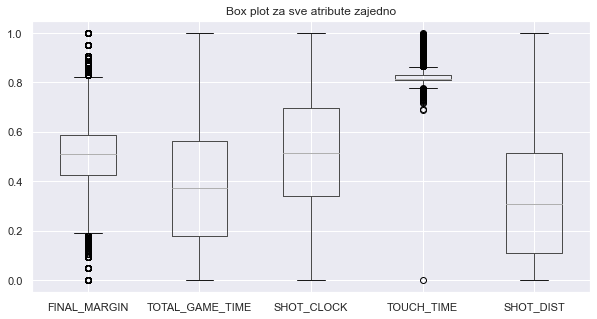

In [17]:
numerical_features = ['FINAL_MARGIN', 'TOTAL_GAME_TIME','SHOT_CLOCK', 'TOUCH_TIME', 'SHOT_DIST']

shot_logs.boxplot(column=numerical_features,figsize=(10,5))
plt.title('Box plot za sve atribute zajedno')
plt.show()

### Korelacija numeričkih varijabli

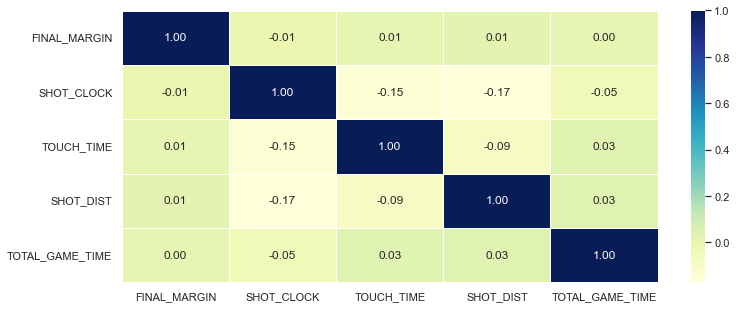

In [18]:
shot_logs_numeric = shot_logs.loc[:,shot_logs.columns.isin(['FINAL_MARGIN', 'TOTAL_GAME_TIME','SHOT_CLOCK', 'TOUCH_TIME', 'SHOT_DIST'])]
sns.set(rc={'figure.figsize':(12,5)})
sns.heatmap(shot_logs_numeric.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.show()

Nema naznaka na jaču korelaciju.

## Primjena raznih algoritama strojnog učenja

Pogledajmo prvo kakav je odnos između broja podataka za svaku klasu za koju se predviđa.

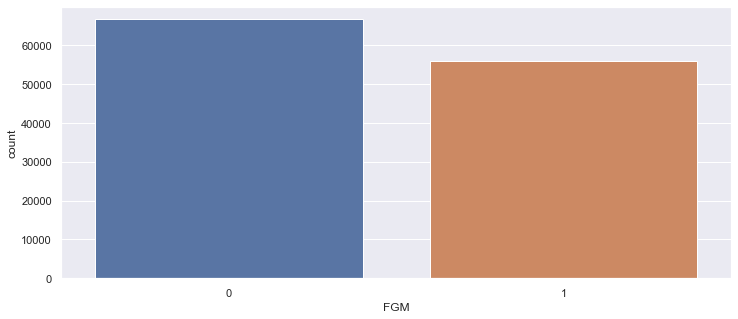

In [19]:
sns.countplot(x='FGM', data=shot_logs)
plt.show()

### Zavisnost pojedinih atributa s izlaznom varijablom


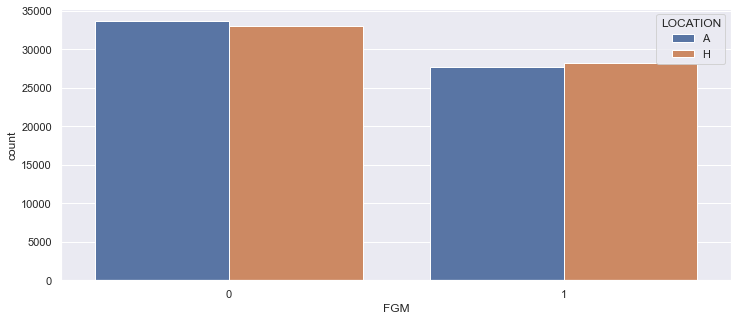

In [20]:
sns.countplot(x='FGM', hue='LOCATION', data=shot_logs)
plt.show()

grafovi prikazuju da je postotak pogođenog šuta bolji kad se igra na domaćem terenu, ali ta razlika nije velika.

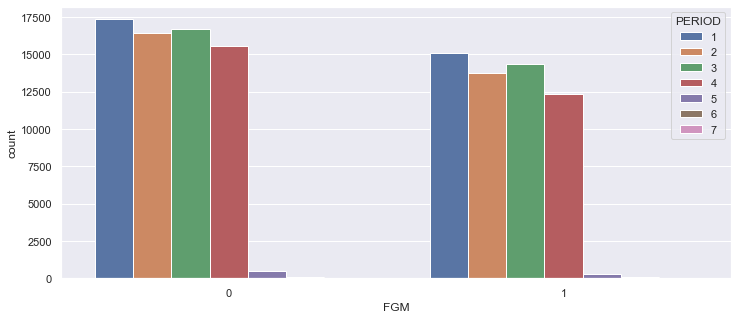

In [21]:
sns.countplot(x='FGM', hue='PERIOD', data=shot_logs)
plt.show()

Grafovi prikazuju da je na ovom datasetu najmanji broj pogođenih šuteva u zadnjoj četvrtini, što može biti možda zbog većeg pritiska u toj četvrtini.

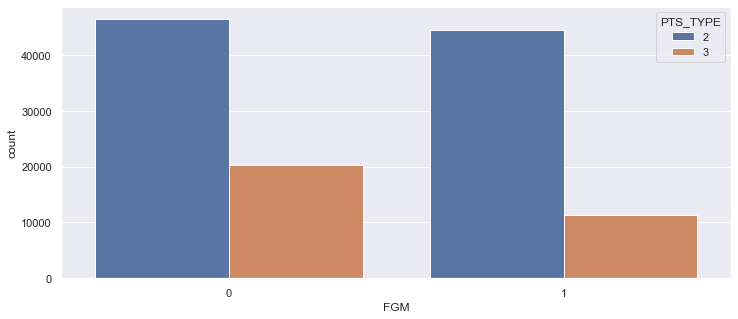

In [22]:
sns.countplot(x='FGM', hue='PTS_TYPE', data=shot_logs)
plt.show()

Grafovi prikazuju da je omjer pogođenog koša/profulanog koša bliži 1:1 kod šuteva za 2 poena, nego za 3 jer je lakše pogoditi šut za dva poena zbog manje udaljenosti od koša.

Za treniranje i predikciju ću koristiti sljedeće atribute:
LOCATION, W, DRIBBLES, SHOT_RESULT, PTS_TYPE, SHOT_NUMBER, FINAL_MARGIN, SHOT_CLOCK, TOUCH_TIME, SHOT_DIST i TOTAL_GAME_TIME

Kategorički su: LOCATION, W, DRIBBLES, SHOT_RESULT, PTS_TYPE i SHOT_NUMBER

Numerički su: FINAL_MARGIN, SHOT_CLOCK, TOUCH_TIME, SHOT_DIST i TOTAL_GAME_TIME

#### Logistička regresija

Kako bi se trenirao model logističke regresije, treba se prvo zamijeniti svi kategorički atributi s dummy vrijednostima.

In [41]:
LOCATION_data = pd.get_dummies(shot_logs['LOCATION'], drop_first = True)
W_data = pd.get_dummies(shot_logs['W'], drop_first = True)
PTS_TYPE_data = pd.get_dummies(shot_logs['PTS_TYPE'], drop_first = True)

shot_logs_logReg = pd.concat([shot_logs, W_data, LOCATION_data, PTS_TYPE_data], axis = 1)

shot_logs_logReg.drop(['LOCATION', 'W', 'SHOT_RESULT', 'PTS_TYPE','GAME_ID','MATCHUP','PERIOD','GAME_CLOCK','DRIBBLES','CLOSEST_DEFENDER_PLAYER_ID','player_id','CLOSEST_DEFENDER','player_name','PTS','SHOT_RESULT'], axis = 1, inplace = True)

In [48]:
print("Atributi za učenje:")
print(shot_logs_logReg.columns)

y_data = shot_logs_logReg['FGM']

x_data = shot_logs_logReg.drop('FGM', axis = 1)
# feature_cols = ['LOCATION', 'W', 'DRIBBLES', 'SHOT_RESULT','PTS_TYPE','SHOT_NUMBER','FINAL_MARGIN', 'TOTAL_GAME_TIME','SHOT_CLOCK', 'TOUCH_TIME', 'SHOT_DIST']
# X = shot_logs[feature_cols] # Features
# y = shot_logs.FGM # Target variable

X_train,X_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=0)

logreg = LogisticRegression(max_iter=1000000)

logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

print("Confusion matrix:")
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)

print("Dodatne informacije o generalizaciji:")
print(classification_report(y_test, y_pred))

Atributi za učenje:
Index([   'FINAL_MARGIN',     'SHOT_NUMBER',      'SHOT_CLOCK',
            'TOUCH_TIME',       'SHOT_DIST',  'CLOSE_DEF_DIST',
                   'FGM', 'TOTAL_GAME_TIME',               'H',
                       3],
      dtype='object')
Confusion matrix:
[[11973  4546]
 [ 7532  6575]]
dodatne informacije o generalizaciji:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66     16519
           1       0.59      0.47      0.52     14107

    accuracy                           0.61     30626
   macro avg       0.60      0.60      0.59     30626
weighted avg       0.60      0.61      0.60     30626



Vidimo da je dobivena preciznost 61%(u članku je 59%)

### SVM

In [50]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print("Confusion matrix:")
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)

print("Dodatne informacije o generalizaciji:")
print(classification_report(y_test, y_pred))

Confusion matrix:
[[10959  5560]
 [ 6896  7211]]
Dodatne informacije o generalizaciji:
              precision    recall  f1-score   support

           0       0.61      0.66      0.64     16519
           1       0.56      0.51      0.54     14107

    accuracy                           0.59     30626
   macro avg       0.59      0.59      0.59     30626
weighted avg       0.59      0.59      0.59     30626



Vidimo da je dobivena preciznost 59%(u članku je 55%)

### Neuronska mreža

Prvo ću trenirati neuronsku mrežu koja koristi sigmoidu kao aktivacijsku funkciju na svim slojevima. 

Karakteristike mreže - 50 neurona u skrivenom sloju, 1 skriveni sloj, 10 epoha

In [56]:
model = Sequential()

model.add(Dense(50, activation='sigmoid', input_shape=(9,)))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
                   
model.fit(X_train, y_train,epochs=10, batch_size=1, verbose=1)

y_pred = model.predict(X_test)

score = model.evaluate(X_test, y_test,verbose=1)

print(score)

Epoch 1/10
91876/91876 [==============================] - 70s 762us/step - loss: 0.6822 - accuracy: 0.5626 59s - loss: 0.6944 - - ETA: 59s - loss: 0.6939 - accuracy:  - ETA: 58s - loss: 0.6936 - - ETA: 57s - loss: 0.6932 - accuracy: 0.537 - ETA: 57s - loss: 0.6932 - accura - ETA: 57s - loss: 0.6932 - E - ETA: 38s - loss: 0.6883 - accuracy: 0 - ETA: 38s - loss: 0.6884 - accurac - ETA: 37s - loss: 0.6883 - acc - ETA: 36s - loss:  - ETA: 25s - loss: 0.6857 - accur - ETA: 25s - loss: 0.6856 - ac - ETA: 24s - loss: 0 - ETA: 1s - loss: 0.682 - ETA: 0s - loss: 0.6822 - accuracy: 0. - ETA: 0s - loss: 0.6
Epoch 2/10
91876/91876 [==============================] - 72s 779us/step - loss: 0.6721 - accuracy: 0.5873 1:00 - loss: 0.6730 - accuracy - ETA: 1:00 - loss: 0 - ETA: 59s - loss: 0.6727 - accuracy: 0. - ETA: 59s - loss: - ETA: 59s - loss: 0.6733 - ac - ETA: 59s - l - ETA: 57s - - ETA: 54s - loss: 0.6726 - accur - ETA: 50s - loss: 0.6726 - accuracy: 0.587 - ET - ETA: - ETA: 40s - loss: 0.6733 -

Vidimo da je dobivena preciznost 60%(u članku je 55%)

Zatim ću trenirati neuronsku mrežu koja koristi relu kao aktivacijsku funkciju na skrivenom sloju i sigmoid aktivacijsku funkciju na izlaznom sloju.

Karakteristike mreže - 50 neurona u skrivenom sloju, 1 skriveni sloj, 10 epoha

In [55]:
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(9,)))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
                   
model.fit(X_train, y_train,epochs=10, batch_size=1, verbose=1)

y_pred = model.predict(X_test)

score = model.evaluate(X_test, y_test,verbose=1)

print(score)


Epoch 1/10
91876/91876 [==============================] - 67s 727us/step - loss: 0.6831 - accuracy: 0.5613s - loss: 0.6833 - accuracy - ETA: 0s -
Epoch 2/10
91876/91876 [==============================] - 71s 767us/step - loss: 0.6744 - accuracy: 0.5849TA: 5s - loss: 0.6747 - accuracy - ETA: 5s - loss: 0.6747 - accuracy:  - - ETA: 1s - loss: 0 - ETA: 1s - loss: 0.6744  - ETA: 0s - loss: 0.6 - ETA: 0s - loss: 0.6
Epoch 3/10
91876/91876 [==============================] - 80s 866us/step - loss: 0.6706 - accuracy: 0.5931 1:02 - loss: 0.6714 - accuracy: 0.58 - ETA: 1:02 - los - ETA: 1:01 - loss: 0.6715 -  - ETA: 1:00 - loss: 0.6717 - accuracy: 0.58 - ETA: 1:00 - lo - ETA: 59s - loss:  - ETA: 57s - loss:  - ETA: 55s - loss: 0.6721 - accuracy - ETA: 55s - loss: 0.6722 -  - ETA: 0s - loss: 0.6707 - accuracy: 0. - ETA: 0s - loss: 0.6706 - accura
Epoch 4/10
91876/91876 [==============================] - 75s 819us/step - loss: 0.6689 - accuracy: 0.5982s - loss: 0 - ETA: 0s - loss: 0
Epoch 5/10
918

Vidimo da je dobivena preciznost 60%(u članku je 55%)

### Naivni Bayesov klasifikator